In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

/blue/weishao/share/conda/envs/shao_lab/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /blue/weishao/share/conda/envs/shao_lab/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import numpy as np
import random
import numpy.random as npr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.image as img
from matplotlib import offsetbox
from PIL import Image
import shutil 
import pandas as pd
import zipfile as zf
from tqdm.auto import tqdm
import yaml
import collections
import json
import random
import matplotlib.patches as patches
import pickle
import cv2
import time
import os
import copy
import math
from time import time
import warnings
%matplotlib inline
plt.style.use('bmh')
warnings.filterwarnings('ignore')

In [4]:
num_of_gpus = torch.cuda.device_count()
print(num_of_gpus)

5


In [7]:
# shutil.rmtree(os.path.join(os.getcwd(),'Data')) # delete entire directory

In [5]:
train_df = pd.read_csv('Train.csv')
train_df = train_df.dropna(how='any')
train_df

,image,m1x1,m1y1,m1x2,m1y2,m1x3,m1y3,m1x4,m1y4,m1x5,...,m2y3,m2x4,m2y4,m2x5,m2y5,m2x6,m2y6,m2x7,m2y7,behaviour
0,mouse001_frameno_1.jpg,487,119,472,147,454,111,457,132,417,...,113,508,105,467,89,493,60,449,57,3
1,mouse001_frameno_2.jpg,488,118,474,148,456,114,459,135,424,...,118,510,110,469,90,496,62,449,58,1
2,mouse001_frameno_3.jpg,491,105,479,143,455,114,462,132,428,...,121,509,114,469,88,504,66,455,59,1
3,mouse001_frameno_4.jpg,484,103,478,138,454,110,460,128,436,...,121,502,113,466,86,502,66,461,57,1
4,mouse001_frameno_5.jpg,482,102,476,130,450,105,456,124,439,...,118,497,112,463,84,505,71,465,56,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154589,mouse018_frameno_6123.jpg,446,249,484,248,467,275,485,266,514,...,119,121,112,87,88,131,69,92,63,3
154590,mouse018_frameno_6124.jpg,451,268,473,254,471,276,484,268,501,...,121,121,113,88,86,131,69,93,62,3
154591,mouse018_frameno_6125.jpg,455,265,475,250,471,277,483,268,506,...,122,118,114,88,87,130,69,93,63,3
154592,mouse018_frameno_6126.jpg,459,261,490,249,485,281,495,267,516,...,124,117,115,89,87,133,72,95,63,3


In [6]:
def classs_arr(label):
    if label == int(1):
        label = 0
    elif label == int(2):
        label = 1 
    else:
        label = 2
    return label

In [7]:
def load_images_labels(df,path):
    X , t =[],[]
    print("Found {} Images".format(len(os.listdir(path))))
    for i in range(len(df)):
        if df['image'][i]:
            img = cv2.imread(path+'/'+df['image'][i])
            X.append(np.array(img).reshape((3,330,600)))
            t.append(int(classs_arr(df['behaviour'][i])))
        else:
            break
    print("Processed all the Images and their corresponding attributes")
    return np.array(X),np.array(t)        

In [8]:
X,t = load_images_labels(train_df,os.path.join(os.getcwd(),'Images','train'))

Found 154594 Images
Processed all the Images and their corresponding attributes


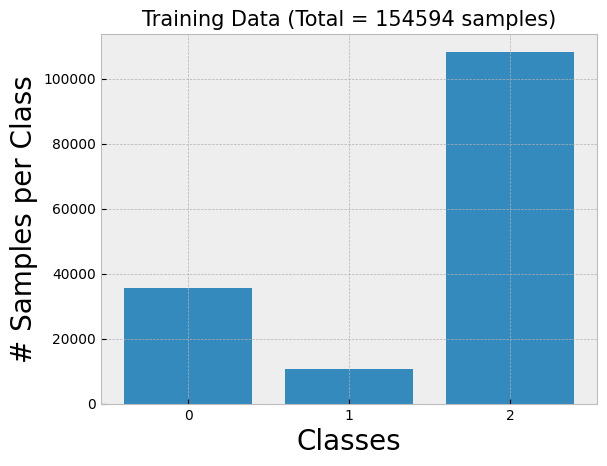

In [9]:
vals, counts = np.unique(t, return_counts=True)

plt.bar(vals, counts)
plt.xticks(range(3),range(3))
plt.xlabel('Classes',size=20)
plt.ylabel('# Samples per Class', size=20)
plt.title('Training Data (Total = '+str(len(t))+' samples)',size=15);

### Frame Visualization

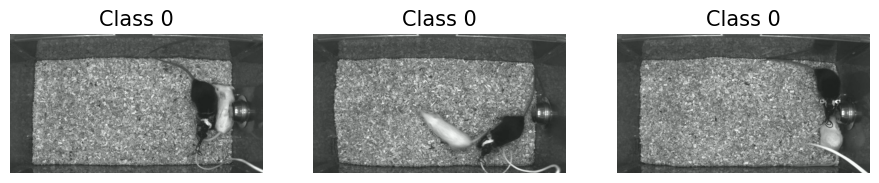

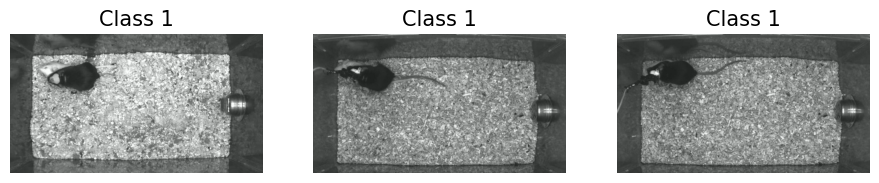

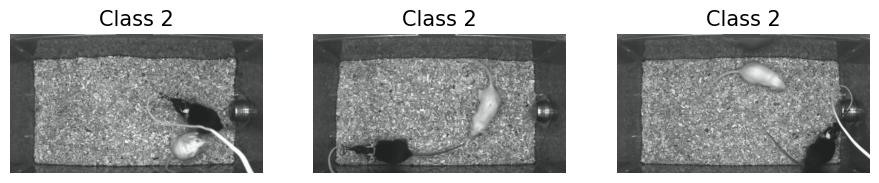

In [10]:
for i in range(0,3):
    rnd_sample = np.random.permutation(np.where(t==i)[0])
    fig=plt.figure(figsize=(15,15))
    for j in range(3):
        fig.add_subplot(4,4,j+1)
        plt.imshow(X[rnd_sample[j],:].reshape((330,600,3)))
        plt.axis('off');plt.title('Class '+str(int(t[rnd_sample[j]])),size=15)
    plt.show()
    print('\n\n')

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,t,shuffle=True,test_size=0.2,stratify=t,random_state=42)

### Data Processing

In [14]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data).float()
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [15]:
train_dataset = CustomDataset(X_train, y_train)

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [17]:
test_dataset = CustomDataset(X_test, y_test)

In [18]:
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [19]:
def Multi_Gpu_Check(model,num_of_gpus):
    if num_of_gpus>1:
        model= nn.DataParallel(model).to(device)
    else:
        model= model.to(device)
    return model

In [20]:
def torch_integer_conv(arr):
    res=[]
    for i in arr:
        i = i .to("cpu")
        i = i.numpy()
        res.append(int(i))
    return np.array(res)

### Model Files

In [21]:
class ResNetClassifier(nn.Module):
    def __init__(self, labels=3):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet101(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, labels)

    def forward(self, x):
        x = self.resnet(x)
        return x

In [22]:
def train_model(model,dataloader, criterion, optimizer, scheduler):
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    
    for images, labels in dataloader:
        inputs = images.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        total += labels.size(0)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        running_corrects += (preds == labels).sum().item()
        
    scheduler.step()
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = running_corrects / total
    return epoch_loss,epoch_acc

In [23]:
def validate_model(model,dataloader,criterion):
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            inputs = images.to(device)
            labels = labels.to(device)
            # Forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            total += labels.size(0)

            # Print statistics
            running_loss += loss.item()
            running_corrects += (preds == labels).sum().item()
            
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = running_corrects / total
    return epoch_loss,epoch_acc

### Hyper Parameter Optimization

In [24]:
def model_optim(model, train_dataloader,val_dataloader,criterion, optimizer, scheduler, num_epochs=25):
    ep,loss1,acc1,loss2,acc2 =[],[],[],[],[]
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        ep.append(epoch)
        # model training
        train_loss,train_acc = train_model(model, train_dataloader, criterion, optimizer, scheduler)
        acc1.append(train_acc)
        loss1.append(train_loss)
        
        #model validation
        val_loss,val_acc = validate_model(model, val_dataloader, criterion)
        acc2.append(val_acc)
        loss2.append(val_loss)
        
        print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {val_acc:.4f}")
        
        # saving a copy of best model parameters 
        if  val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
    print()    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Test Accuracy:{:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,best_acc*100

In [25]:
import time

In [26]:
model = ResNetClassifier()

model = Multi_Gpu_Check(model,num_of_gpus)

criterion = nn.CrossEntropyLoss()

In [27]:
ne=[8,16]
lrv = [0.0001,0.001]
ss =[7,9]
param=[]
sc=[]
print("\n Performing Custom Search For Best Parameters")
since = time.time()
for i in range(len(ne)):
    for j in range(len(lrv)):
        for k in range(len(ss)):
          tmp =(ne[i],lrv[j],ss[k])
          print("\n Training a model with a learning rate of {0},step size {1} and an epoch count of {2}".format(lrv[j],ss[k],ne[i]))
          param.append(tmp)
          optimizer = optim.Adam(model.parameters(), lr=lrv[j])
          step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=ss[k], gamma=0.1)
          model,acc = model_optim(model,train_dataloader,test_dataloader, criterion, optimizer, step_lr_scheduler, num_epochs=ne[i])
          sc.append(acc)
bacc = max(sc)
loc = np.where(np.array(sc)==bacc)[0][0]
ne_v = param[loc][0]
lr_v = param[loc][1]
ss_v = param[loc][2]
time_elapsed = time.time() - since
print("The search for optimal parameters for the model has completed after:{:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
print("\nThe optimal parameters are given as follows - learning rate:{0},step size:{1} and a fixed number of epochs:{2}".format(lr_v,ss_v,ne_v))


 Performing Custom Search For Best Parameters

 Training a model with a learning rate of 0.0001,step size 7 and an epoch count of 8
Epoch 0/7
----------
train Loss: 0.3504 Acc: 0.8643
test Loss: 0.2226 Acc: 0.9187

Epoch 1/7
----------
train Loss: 0.1303 Acc: 0.9540
test Loss: 0.1349 Acc: 0.9529

Epoch 2/7
----------
train Loss: 0.0844 Acc: 0.9717
test Loss: 0.1405 Acc: 0.9545

Epoch 3/7
----------
train Loss: 0.0636 Acc: 0.9794
test Loss: 0.1117 Acc: 0.9643

Epoch 4/7
----------
train Loss: 0.0498 Acc: 0.9842
test Loss: 0.0693 Acc: 0.9779

Epoch 5/7
----------
train Loss: 0.0419 Acc: 0.9869
test Loss: 0.1628 Acc: 0.9461

Epoch 6/7
----------
train Loss: 0.0354 Acc: 0.9892
test Loss: 0.0624 Acc: 0.9805

Epoch 7/7
----------
train Loss: 0.0096 Acc: 0.9972
test Loss: 0.0353 Acc: 0.9891

Training complete in 191m 44s
Best test Acc: 0.989062

 Training a model with a learning rate of 0.0001,step size 9 and an epoch count of 8
Epoch 0/7
----------
train Loss: 0.0321 Acc: 0.9906
test Loss: 

### Final Model Training

In [27]:
def model_main(model, train_dataloader,val_dataloader,criterion, optimizer, scheduler, num_epochs=25):
    ep,loss1,acc1,loss2,acc2 =[],[],[],[],[]
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        ep.append(epoch)
        # model training
        train_loss,train_acc = train_model(model, train_dataloader, criterion, optimizer, scheduler)
        acc1.append(train_acc)
        loss1.append(train_loss)
        
        #model validation
        val_loss,val_acc = validate_model(model, val_dataloader, criterion)
        acc2.append(val_acc)
        loss2.append(val_loss)
        
        print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {val_acc:.4f}")
        
        # saving a copy of best model parameters 
        if  val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
    print()    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Test Accuracy:{:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,acc1,acc2,np.array(loss1),np.array(loss2),np.array(ep)

In [28]:
import time

In [30]:
model = ResNetClassifier()

model = Multi_Gpu_Check(model,num_of_gpus)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=lr_v)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=ss_v, gamma=0.1)

model,acc1,acc2,loss1,loss2,epochs = model_main(model,train_dataloader,test_dataloader,criterion, optimizer, step_lr_scheduler, num_epochs=ne_v)

Epoch 0/15
----------
Train Accuracy: 0.8902, Test Accuracy: 0.9805
Epoch 1/15
----------
Train Accuracy: 0.9625, Test Accuracy: 0.9890
Epoch 2/15
----------
Train Accuracy: 0.9824, Test Accuracy: 0.9605
Epoch 3/15
----------
Train Accuracy: 0.9829, Test Accuracy: 0.9840
Epoch 4/15
----------
Train Accuracy: 0.9859, Test Accuracy: 0.9920
Epoch 5/15
----------
Train Accuracy: 0.9885, Test Accuracy: 0.9850
Epoch 6/15
----------
Train Accuracy: 0.9890, Test Accuracy: 0.9865
Epoch 7/15
----------
Train Accuracy: 0.9921, Test Accuracy: 0.9915
Epoch 8/15
----------
Train Accuracy: 0.9921, Test Accuracy: 0.9885
Epoch 9/15
----------
Train Accuracy: 0.9969, Test Accuracy: 0.9935
Epoch 10/15
----------
Train Accuracy: 0.9991, Test Accuracy: 0.9950
Epoch 11/15
----------
Train Accuracy: 0.9998, Test Accuracy: 0.9955
Epoch 12/15
----------
Train Accuracy: 0.9999, Test Accuracy: 0.9955
Epoch 13/15
----------
Train Accuracy: 0.9999, Test Accuracy: 0.9950
Epoch 14/15
----------
Train Accuracy: 1.000

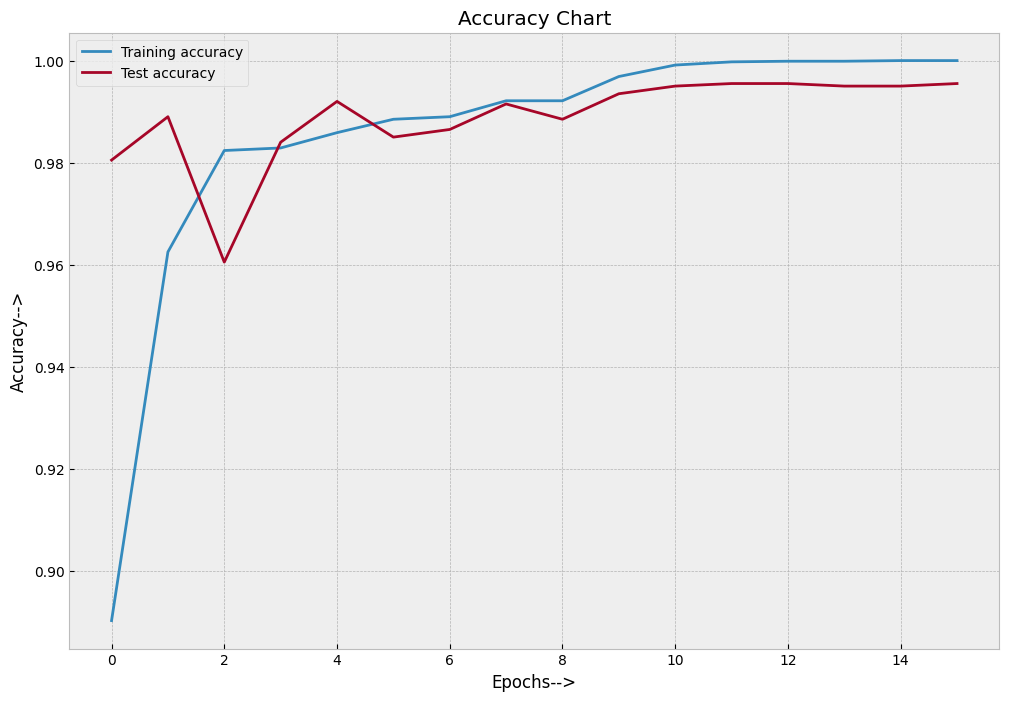

In [31]:
plt.figure(figsize =(12, 8))
plt.grid(visible=True)
plt.plot(epochs,acc1, label='Training accuracy')
plt.plot(epochs,acc2, label='Test accuracy')
plt.title('Accuracy Chart')
plt.xlabel('Epochs-->')
plt.ylabel('Accuracy-->')
plt.legend()
plt.savefig('Accuracy.png');

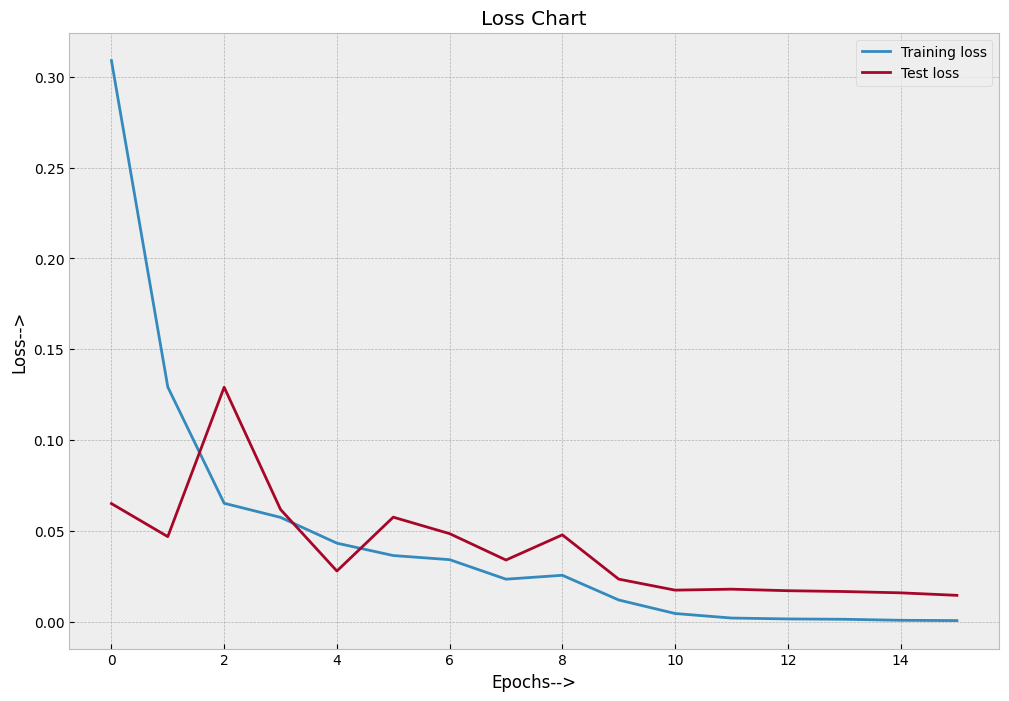

In [32]:
plt.figure(figsize =(12, 8))
plt.grid(visible=True)
plt.plot(epochs,loss1, label='Training loss')
plt.plot(epochs,loss2, label='Test loss')
plt.title('Loss Chart')
plt.xlabel('Epochs-->')
plt.ylabel('Loss-->')
plt.legend()
plt.savefig('Loss.png');

In [33]:
print('Finished Training')
device = torch.device("cuda:0")
model.to(device)
PATH = './MBAS-ResNet-101-CLS.pth'
torch.save(model, PATH)

Finished Training
